In [1]:
%matplotlib inline
import numpy as np
from numpy import random
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from operator import add
import itertools
from scipy import signal
import seaborn as sns
import nest



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 15:12:16

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
import os
import sys
Path = os.getcwd()
sys.path.append(Path)
print(os.getcwd())
from utilities1 import *
from build_simulation import *

/mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks


In [3]:
def find_I(V_target_si, f, tau_si=10e-3, R_si=100e6, E_m_si=-60e-3):
    a_si = (-E_m_si+V_target_si) * math.sqrt(1 + (2*math.pi*f*tau_si)**2) / R_si
    a = a_si/(1e-12)
    print(f"I_amp for f={f}: {a:.1f}pA")

def isi_dist(ts):
    isi = []
    
    for i in range(len(ts)-1):
        isi.append(ts[i+1]-ts[i])
    plt.figure()
    plt.hist(isi, bins=10, histtype='step')
    plt.title("Histogram")
    plt.ylabel("Frequency")
    plt.xlabel("Interspike interval")

In [60]:
def plot_results(sim_time=5000, noisy=False, psd_segments=16, 
                  second_sine=False, xLim=0, a_values=[100],
                 SD_values=[250], f_values=[10], beat=20,
                 E_m=-60, V_th=-50, bin_size=1, 
                seed=np.random.randint(0,1e+6), resolution=0.25, 
                 legend=False, log=True, y_min=1e-7, harmonics=1,
                 harmonics_beat=0, save_fig=False):
    
    """This function plots:
    - Membrane potential as a function of time for a given length within simulation time (xLim)
    - The PSD of the spike train
    - The PSD of the membrane potential
        noisy: whether to include noise or not (True/False)
        sim_time: duration of simulation (ms)
        psd_segments: number of segments in welch psd
        second_sine : whether to include second AC generator or not (True/False)
        xLim : limiting the time axis of the membrane potential (max value) (ms)
        a_values : input amplitudes (pA)
        SD_values : input noise level (standard deviation) (pA)
        f_values : input frequencies (Hz)
        beat : frequency offset (Hz)
        E_m : resting potential (mV)
        V_th : Threshold for firing action potentials (mV)
        bin_size : width of frequency (Hz)
        seed : random number (or set by user for control).
        Necessary for generation of stochastic noise,
        resolution : temporal resolution/length of time steps (ms)
        legend : Whether to put legend outside plots (True/False)
        log : Whether to use loglog-plot or not (True/False)
        y_min : min value for PSD of spike train (varies a lot)
        harmonics : number of harmonics of input frequencies indicated in PSD-plot
        harmonics_beat : number of harmonics of beat frequency indicated in PSD- plot"""    
    
    ###*************************SIMULATION***********************************
    if noisy:
        param_combos = [
        (f, a, sd) for f, a, sd in itertools.product(f_values, a_values, SD_values)
        if not (a == 0 and sd == 0)
        ]
    else:
        param_combos = list(itertools.product(f_values, a_values))
    
    param_combos = np.atleast_1d(param_combos) #to allow for one single combination
    
        
    fig, axes = plt.subplots(nrows=len(param_combos), ncols=3, 
                             figsize=(15, 5*len(param_combos)))
    
    if len(param_combos) == 1:
        axes = np.array([axes])
    
    for idx, combo  in enumerate(param_combos):
        if noisy:
            
            f, a, sd = combo
                    
        else:
            
            f,a = combo
                
          
        results = build_simulation(sim_time=sim_time, noisy=noisy,
                                f1=f, a=a, SD=sd, V_thresh=V_th, E_m=E_m, 
                                   second_sine=second_sine,
                                    seed=seed, resolution=resolution)
                
         #********************************RESULTS AND PLOTS********************************   
        spike_times = results["spike_times"]
        Vm = results["Vm"]
        V_th = results["V_th"]
        sim_time = results["sim_time"]
        times = results["times"]

        #Background
        sns.set_style("whitegrid")
        plt.rcParams["font.family"] = "Liberation Serif"
        # Membrane potential with threshold 
        
        ax_vm = axes[idx,0]
        time_axis = np.linspace(0,sim_time,len(Vm))
        
        for t in spike_times:
            ax_vm.vlines(x=t, ymin=V_th, ymax=V_th+5, color="black") 
            
        ax_vm.plot(time_axis, Vm, color='#006D5B')
        
        ax_vm.axhline(V_th, linestyle='-', color='black', label="V_th")  # terskel-linje
        
        #-----------------TITLES---------------------
        letters = "ABCDEFGHIJKLMN"
        
        if noisy:
            if second_sine:
                title = rf"{letters[3*idx]}. $V_m$ ($f_1$ = {f:.0f}Hz, $f_2$ = {(f+beat):.0f}Hz, " + rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)"
            else:
                title =  rf"{letters[3*idx]}. $V_m$ ($f$ = {f:.0f}Hz, $\sigma_I$ = {sd:.0f}pA, " + rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)"
             
        else:
            if second_sine:
                title = rf"{letters[3*idx]}. $V_m$ ($f_1$ = {f:.0f}Hz, $f_2$ = {(f+beat):.0f}Hz, " + rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)"
            else:
                title = rf"{letters[3*idx]}. $V_m$ ($f$ = {f:.0f}Hz, $I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)"
                
                
        if a == 0:
            
            if second_sine == False:
                title = title.replace(r"($f$ = " + f"{f:.0f}" + r"Hz, ", "(")
    
            if second_sine: 
                title = title.replace(r"($f_1$ = " + f"{f:.0f}" + r"Hz, $f_2$ = " + f"{f + beat:.0f}" + r"Hz, ", "(")
        
        ax_vm.set_title(title,fontsize=18, fontweight='bold', color="#006D5B")
        
            


        ax_vm.set_xlim([0, sim_time])
        if xLim != 0:
            ax_vm.set_xlim(1000, 1000+1000*xLim) 
        dV = np.max(Vm-E_m)
        #ax_vm.set_ylim([np.min(Vm)-0.03*dV,np.max(Vm)+0.5*dV])
        ax_vm.set_ylim([-70,-48])
        #ax_vm.set_ylim(-65,-55)
        ax_vm.set_xlabel("Time [ms]", color="#006D5B", fontsize=16)
        ax_vm.set_ylabel("$V_m$ [mV]", color="#006D5B",fontsize=16)
        
        #chat-gpt:
        ax_vm.set_facecolor("#F5F5F5")
        ax_vm.spines["top"].set_visible(False)
        ax_vm.spines["right"].set_visible(False)
        ax_vm.spines["left"].set_color("#333333")
        ax_vm.spines["bottom"].set_color("#333333")
        ax_vm.xaxis.label.set_color("#006D5B")
        ax_vm.yaxis.label.set_color("#006D5B")
        ax_vm.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_vm.grid(color='#A3D4CC', linestyle='-', linewidth=0.5)
        ax_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333", fontsize=16)
        
    
        
        # PSD of spike train
        
        freqs, psd_values = psd(spike_times, sim_time, bin_size, segments=psd_segments)
        arg_f = np.argmin(np.abs(freqs - f))
        if second_sine:
            arg_f = np.argmin(np.abs(freqs - f))
        ax_fft = axes[idx,1]
        
        
        # Vertical lines, colors filled in by chat GPT
        
        beat_colors = ["#1E3A8A", "#2563EB", "#60A5FA", "#38BDF8"] #Blue colors for beat frequencies
        colors = ["#009879", "#4CAF50", "#8BC34A", "#CDDC39", "#FFEB3B"]  # Green colors for harmonics
        
        for i in range(1,harmonics_beat+1):
            ax_fft.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"f={i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"f={i*f}Hz")
            if second_sine:
                ax_fft.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"f={i*(f+beat)}Hz")
            ax_fft.legend()
        
        keep_args = psd_values > 1e-30
        psd_values = psd_values[keep_args]
        freqs = freqs[keep_args]
        
        ax_fft.plot(freqs, psd_values, color="#006D5B") 
        if len(freqs) > 0:
            xMax = max(f,np.max(freqs))*1.1
            
            
        #-----------Create empty log-plot if there are no PSD-values----------   
        if len(psd_values) == 0:
        
            ax_fft.loglog([1], [1e-16], alpha=0)  
            ax_fft.set_xlim(1, 2e3)
            ax_fft.set_ylim(1e-16, 1e-10)
            ax_fft.set_title("PSD of spike train (No spikes)", fontsize=14, fontweight="bold", color="#006D5B")
            ax_fft.set_xscale("log")
            ax_fft.set_yscale("log")
            
        if len(psd_values) > 0:
            ymin = max(3e-5, np.min(np.abs(psd_values)))
            ax_fft.set_ylim(ymin,np.max(np.abs(psd_values))*1.1)
            ax_fft.set_xscale("log")
            ax_fft.set_yscale("log")
        
        ax_fft.set_xlim(1,2e3)
        ax_fft.set_xlabel("Frequency (Hz)", color="#006D5B", fontsize=16)
        ax_fft.set_ylabel(r'PSD [$\mathrm{spikes}^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft.set_title(f"{letters[1+3*idx]}. PSD of spike train", fontsize=20, fontweight='bold', color="#006D5B")
        
        # Generated by ChatGPT (adapted afterwards):
        ax_fft.set_facecolor("#F5F5F5")
        ax_fft.spines["top"].set_visible(False)
        ax_fft.spines["right"].set_visible(False)
        ax_fft.spines["left"].set_color("#333333")
        ax_fft.spines["bottom"].set_color("#333333")
        ax_fft.xaxis.label.set_color("#006D5B")
        ax_fft.yaxis.label.set_color("#006D5B")
        ax_fft.tick_params(axis='both', colors="#333333", labelsize='large')
        
        # enabling placement of legend outside plots if necessary
        if legend:
            ax_fft.legend(edgecolor="#333333", fontsize=16, loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=3)
        else:
            ax_fft.legend(facecolor="white", framealpha=1, edgecolor="#333333", fontsize=16)
        
        # Calculating simulated SNR
        if len(psd_values) > 0:
            if noisy:
                if second_sine:
                    df, noise_avg = simulated_SNR(Vm, a, psd_values, f, freqs, 
                      arg_f, sim_time, sd, beat, spike_times, second_sine)
                else:
                    df, noise_avg = simulated_SNR(Vm, a, psd_values, f, freqs, 
                      arg_f, sim_time, sd, beat, spike_times, second_sine)   
                    
                display(df)
          
    
        # PSD of membrane potential
        freqs, psd_vm = psd_Vm(Vm, times, resolution)
        psd_vm = np.abs(psd_vm)
        keep_args = psd_vm > 1e-30
        psd_vm = psd_vm[keep_args]
        freqs = freqs[keep_args]
    
        ax_fft_vm = axes[idx,2]
        for i in range(1,harmonics_beat+1):
            ax_fft_vm.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"f={i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft_vm.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"f={i*f:.0f}Hz")
            if second_sine:
                ax_fft_vm.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"f={i*(f+beat):.0f}Hz")
            
    
        
        ax_fft_vm.plot(freqs, np.abs(psd_vm), color='#006D5B')  
        ax_fft_vm.set_xlim(1, 2e3)           
        if len(psd_vm) > 0:
            ymin = max(y_min, np.min(np.abs(psd_vm)))
            ax_fft_vm.set_ylim(ymin,10*np.max(np.abs(psd_vm)))
      
        ax_fft_vm.set_xlabel("Frequency [Hz]", color="#006D5B", fontsize=16)
        ax_fft_vm.set_ylabel(r'PSD [$\mathrm{mV}^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft_vm.set_title(f"{letters[2+3*idx]}. PSD of $V_m$", fontsize=20, fontweight='bold', color="#006D5B")
        
        if log and len(psd_vm)>0:
            ax_fft_vm.set_xscale("log")
            ax_fft_vm.set_yscale("log")
        
        #generated by chatGPT
        ax_fft_vm.set_facecolor("#F5F5F5")
        ax_fft_vm.spines["top"].set_visible(False)
        ax_fft_vm.spines["right"].set_visible(False)
        ax_fft_vm.spines["left"].set_color("#333333")
        ax_fft_vm.spines["bottom"].set_color("#333333")
        ax_fft_vm.xaxis.label.set_color("#006D5B")
        ax_fft_vm.yaxis.label.set_color("#006D5B")
        ax_fft_vm.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_fft_vm.grid(color='#B0B0B0', linestyle='-', linewidth=0.5)
    
        if legend:
            continue
        else:
            ax_fft_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333", fontsize=16)
        
    
    plt.tight_layout()
    if save_fig:
        save_dir = os.path.join(os.getcwd(), "results")
        os.makedirs(save_dir, exist_ok=True)
        file_index = 1
        while os.path.exists(os.path.join(save_dir, f"main_{file_index}.png")):
            file_index += 1
        
        save_path = os.path.join(save_dir, f"main_{file_index}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        
        print(f"Saved plot as: {save_path}")
        
    plt.show()
    
    
    
    

In [53]:
import math 

def calculate_SD(tau_si, C_m_si, Vm_SD, delta):
    SD_si = math.sqrt( (2 * C_m_si**2 * Vm_SD**2) / (delta * tau_si ))
    SD = SD_si / (1e-12)
    return SD

SD = calculate_SD(tau_si=10*1e-3, C_m_si=100*1e-12, Vm_SD=4.0*1e-3, delta=5e-4)
print(f"Resolution = 1.0 ms. SD I_noise: {SD:.2f} pA")


Resolution = 1.0 ms. SD I_noise: 252.98 pA


In [35]:
find_I(-51e-3, 10)

I_amp for f=10: 106.3pA


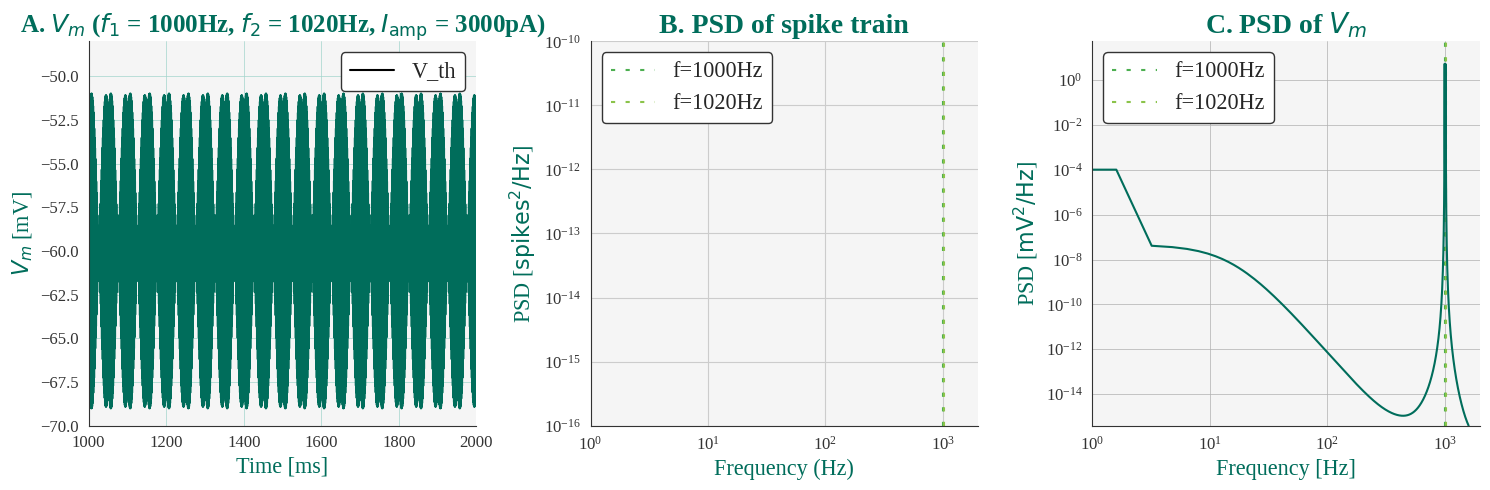

In [36]:
plot_results(sim_time=10e3,
             a_values=[3000],f_values=[1000], SD_values=[0],
             noisy=False, xLim=1, seed=2,V_th=0,
             bin_size=0.25, second_sine=True, harmonics=1,beat=20,
             resolution=0.25, y_min=1e-16)

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_65.png


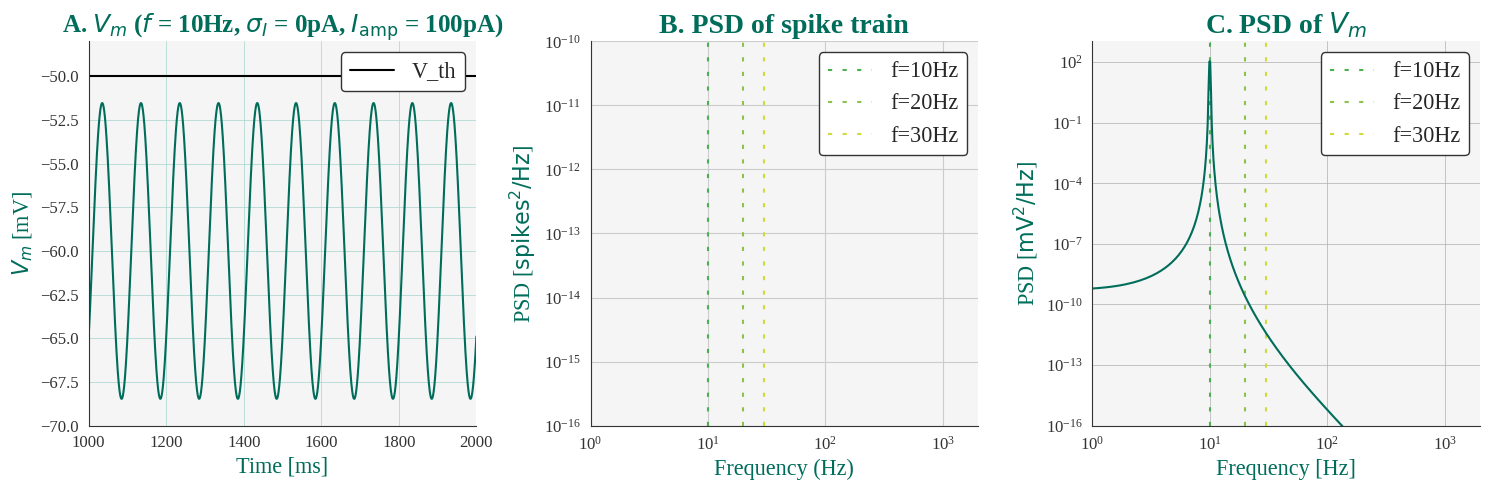

In [61]:
plot_results(sim_time=100e3,
             a_values=[100],f_values=[10], SD_values=[0],
             noisy=True, xLim=1, seed=2,
             bin_size=0.25, second_sine=False, harmonics=3,
            save_fig=True, resolution=0.25, y_min=1e-16)

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_56.png


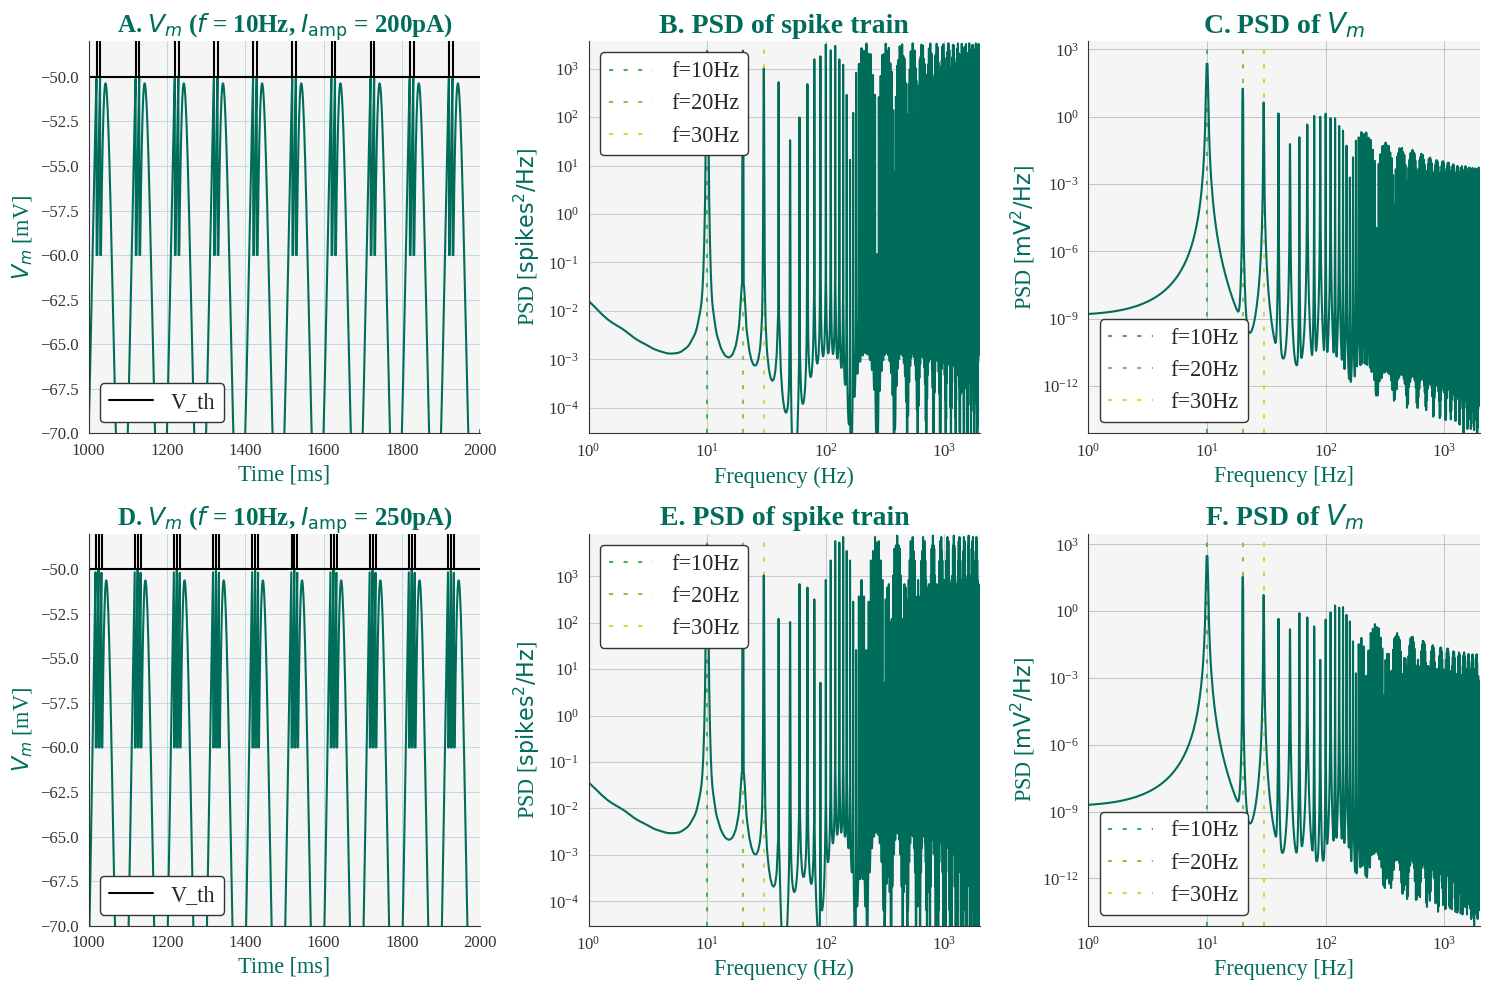

In [41]:
plot_results(sim_time=100e3,
             a_values=[200,250],SD_values=[250], f_values=[10], 
             noisy=False, xLim=1, seed=2, bin_size=0.25, second_sine=False,
             harmonics=3,save_fig=True, resolution=0.25, y_min=1e-16)

In [42]:
find_I(-51e-3, 1000)

I_amp for f=1000: 5655.6pA


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),SNR,noise average,Spike Rate (spikes/s)
0,100,100,-50.003088,38.09,38.09,100.0,5.74,6.64,3.16


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_66.png


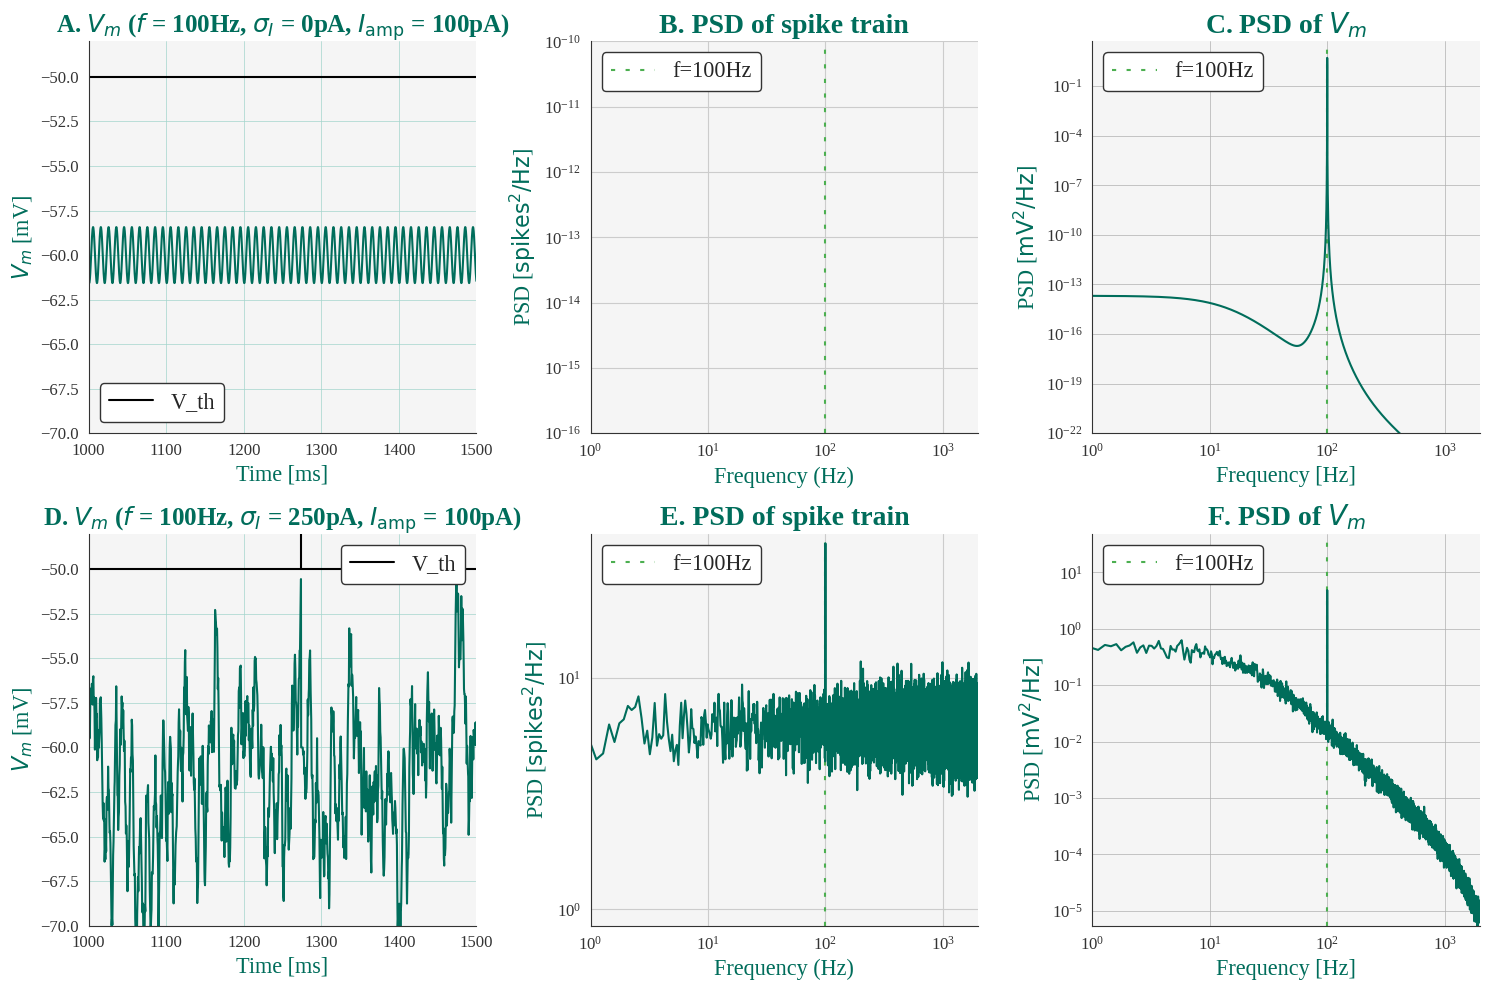

In [62]:
plot_results(sim_time=100000,save_fig=True,
             a_values=[100],f_values=[100], SD_values=[0,250],
             noisy=True, seed=42, bin_size=0.25, second_sine=False, 
             resolution=0.25, xLim=0.5, y_min=1e-22)

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_58.png


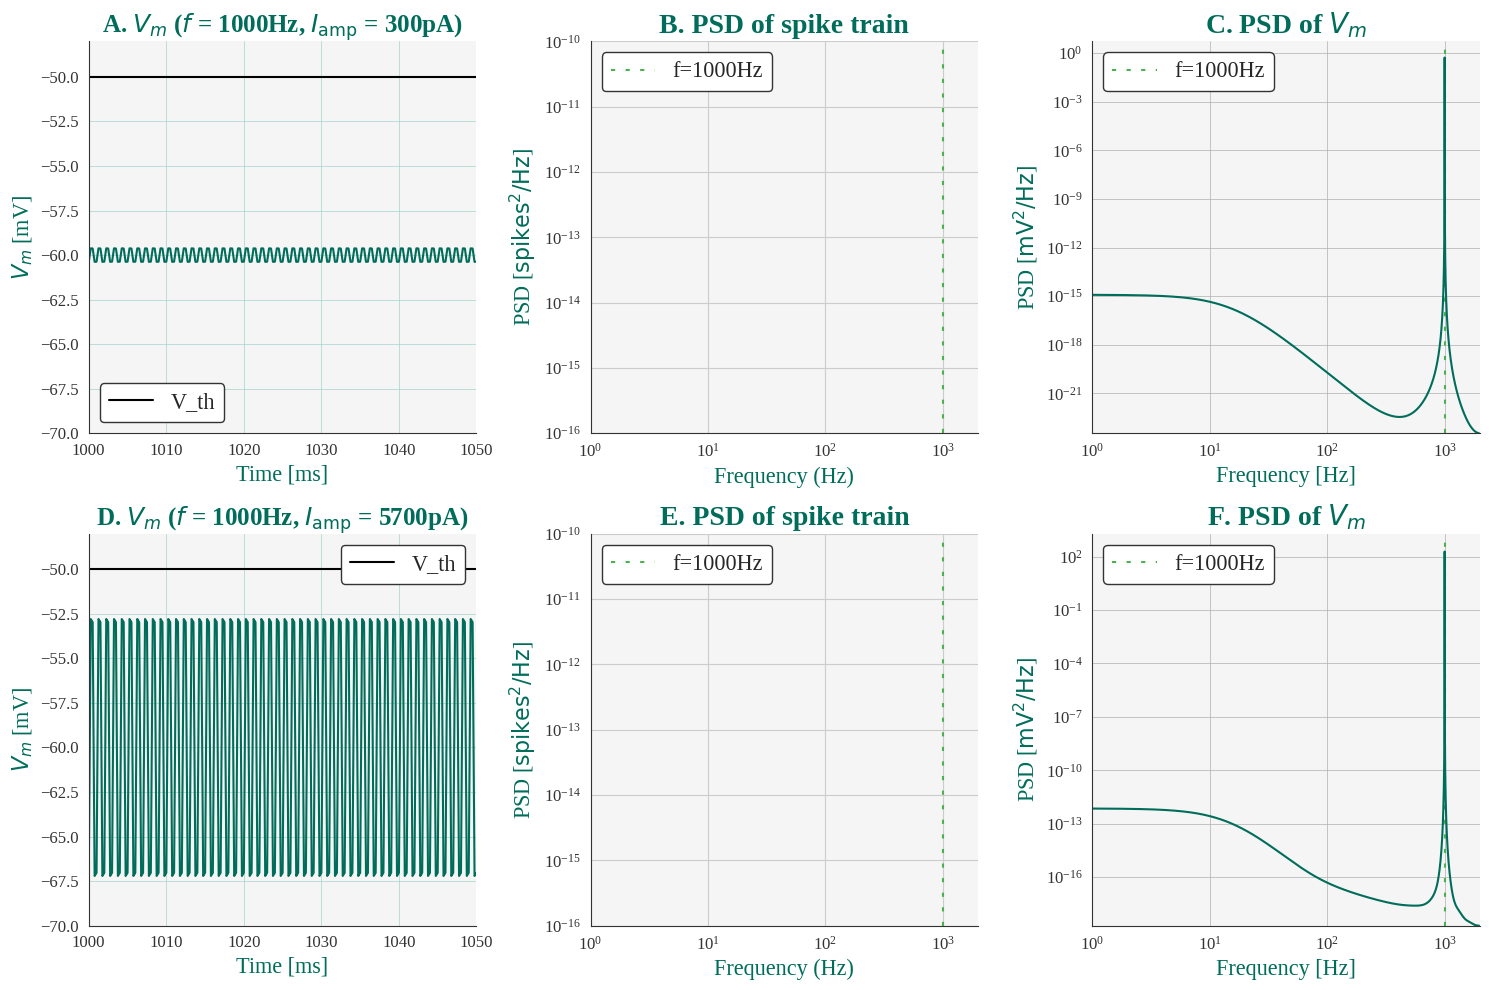

In [44]:
plot_results(sim_time=100e3, SD_values=[0],
             a_values=[300,5700],f_values=[1000],
             noisy=False, xLim=0.05, seed=42, bin_size=0.25, second_sine=False, 
            harmonics=1, save_fig=True, log=True, resolution=0.25, y_min=1e-24)

,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),SNR,noise average,Spike Rate (spikes/s)
0,1000,100,-50.000156,9.2,6.71,58.4,1.3,5.15,2.49


,Input Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],FFT Amplitude for f [(spikes pr sec)/Hz],Frequency at max (Hz),SNR,noise average,Spike Rate (spikes/s)
0,1000,300,-50.000061,14.67,14.67,1000.0,2.71,5.42,2.6


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_59.png


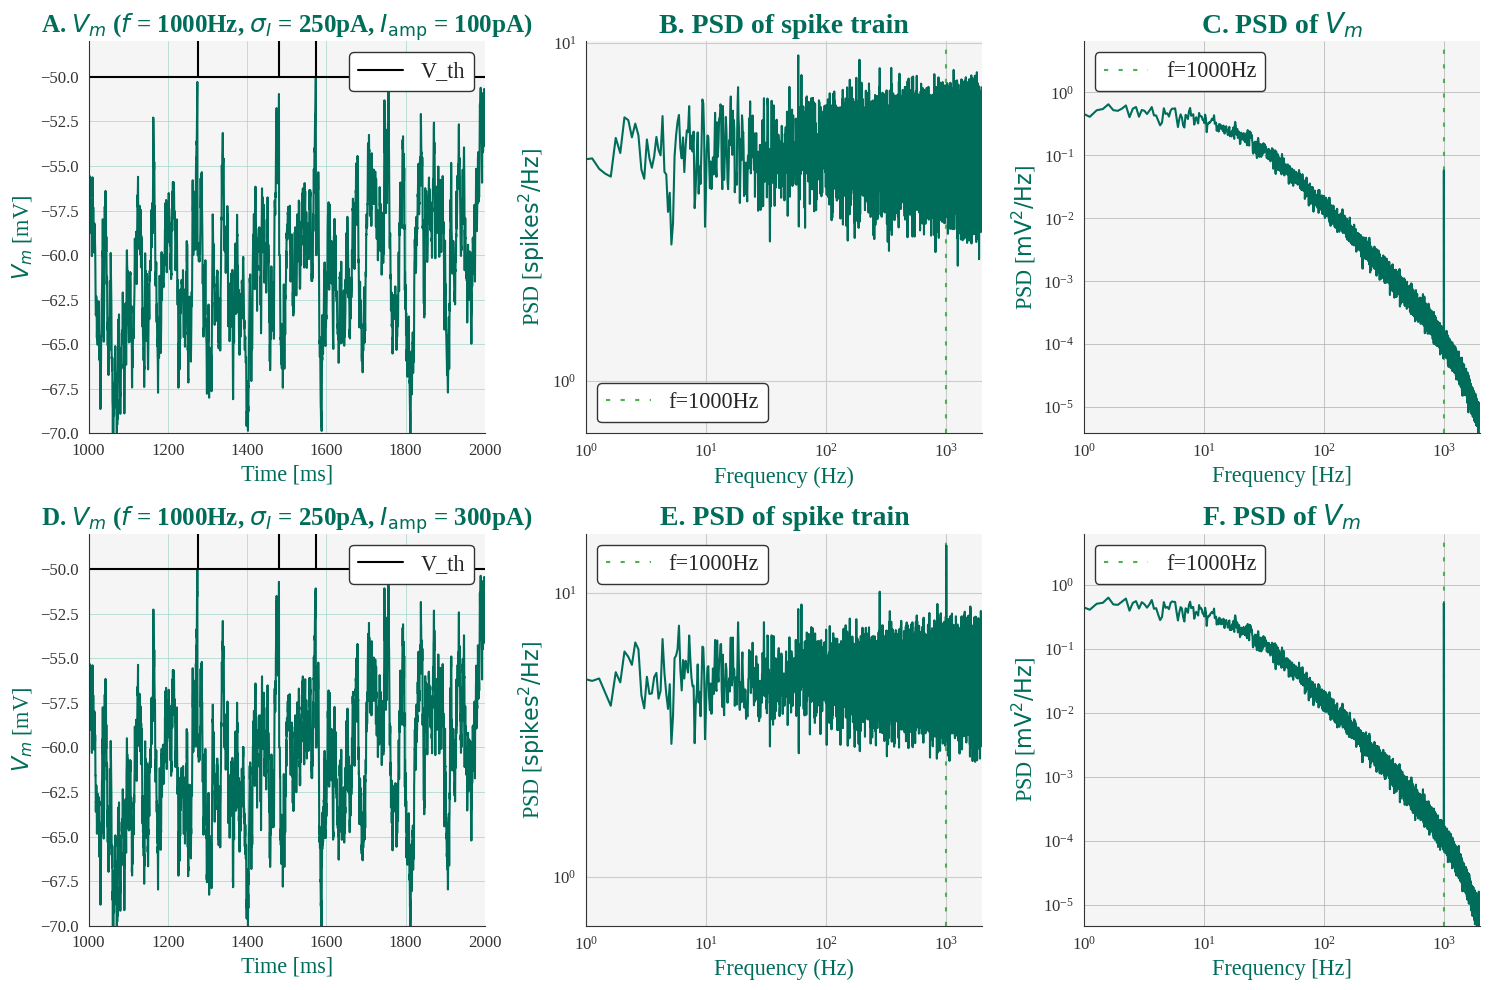

In [46]:
plot_results(sim_time=100e3, SD_values=[250],
             a_values=[100,300],f_values=[1000],
             noisy=True, xLim=1, seed=42, bin_size=0.25, second_sine=False, 
            harmonics=1, save_fig=True, resolution=0.25, y_min=1e-16)

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_60.png


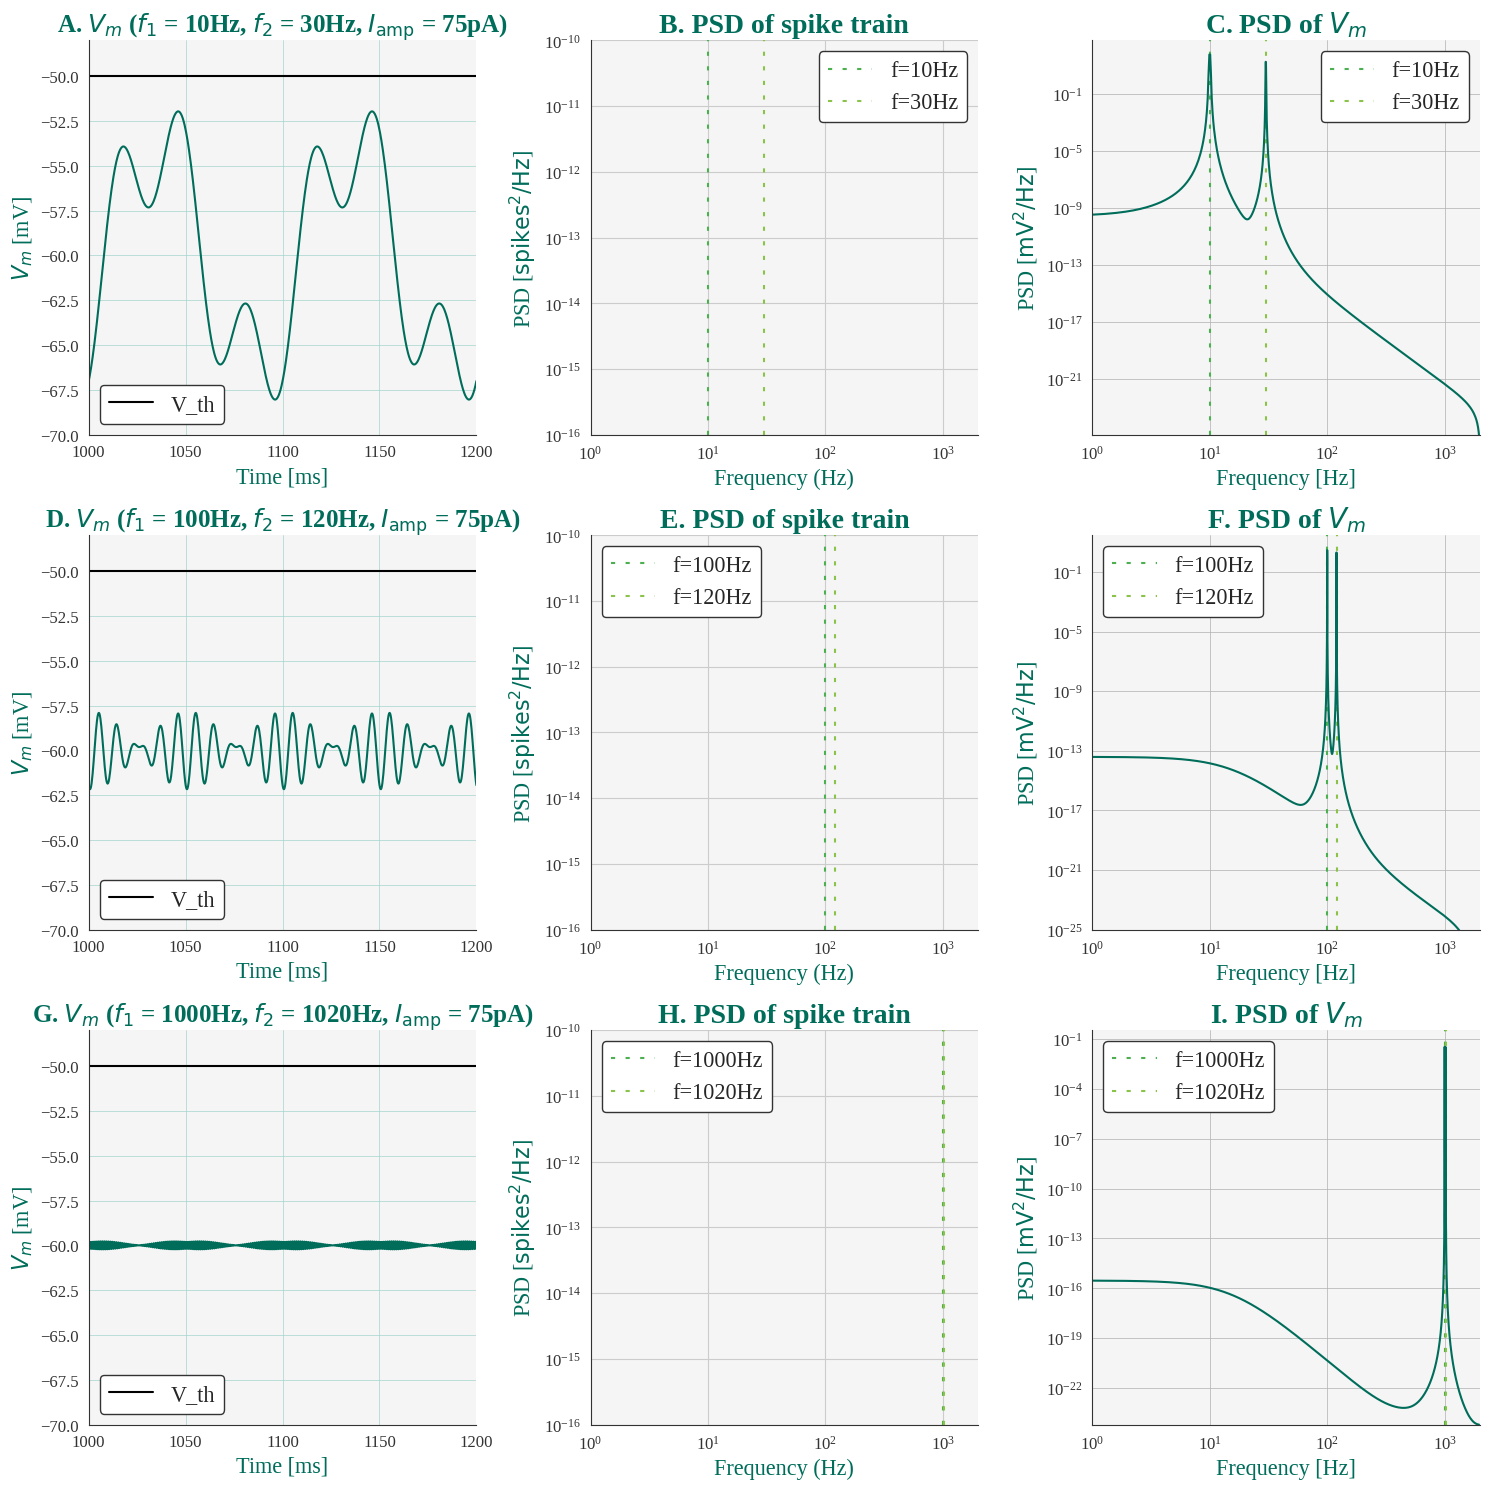

In [47]:
"""Dobbel sinus uten noise """
plot_results(sim_time=100e3,a_values=[75], f_values=[10,100,1000], noisy=False,
             second_sine=True, beat=20, xLim=0.2, seed=42, harmonics=1, psd_segments=16,
             bin_size=0.25, resolution=0.25,  save_fig=True, y_min=1e-25)

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_61.png


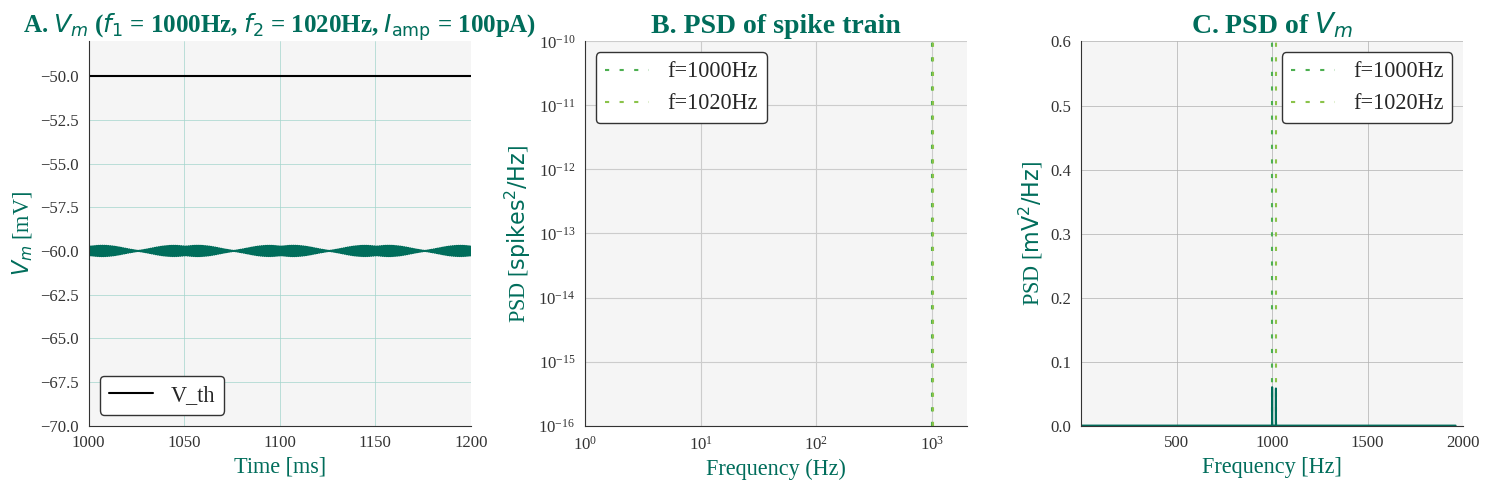

In [48]:
""" to make sure there are two and not only one peak"""
plot_results(sim_time=100e3,a_values=[100], f_values=[1000], noisy=False, log=False,
             second_sine=True, beat=20, xLim=0.2, seed=42, harmonics=1, psd_segments=16,
             bin_size=0.25, resolution=0.25, save_fig=True, y_min=1e-16)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat)
0,"[10, 30]",20,100,-50.000036,722.17,719.25,78.05,10.08,27.88,25.8,16.25,4.9,15.9


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_62.png


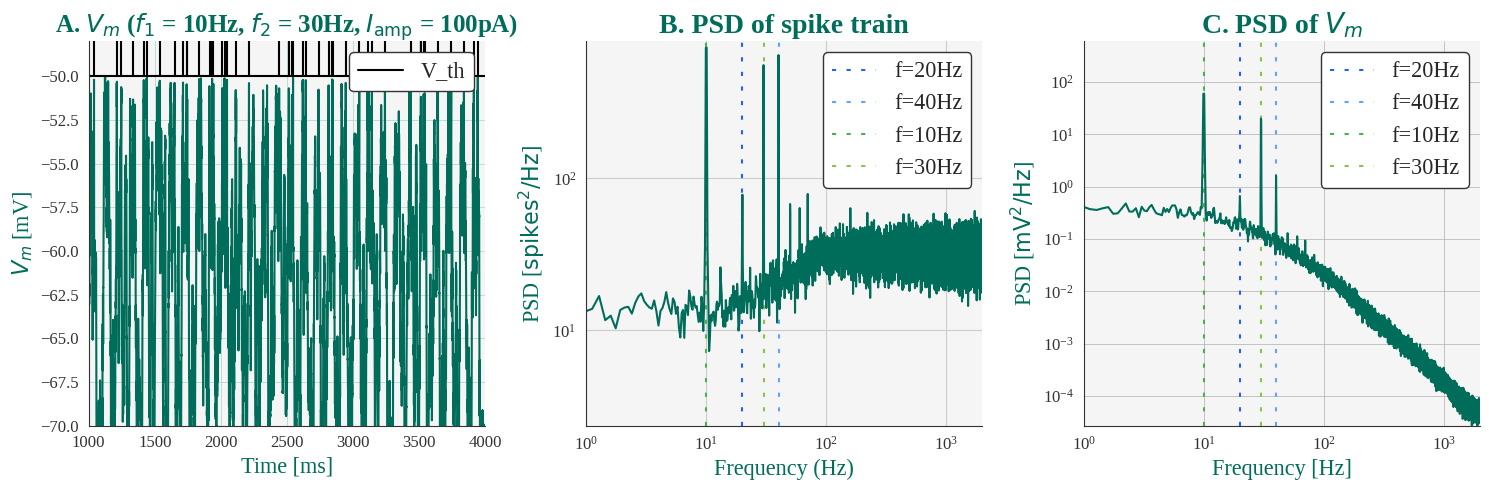

In [54]:
plot_results(sim_time=100e3, SD_values=[250],
             a_values=[100], f_values=[10], second_sine=True, beat=20, psd_segments=16,
             noisy=True, xLim=3, seed=42, bin_size=0.25, resolution=0.25, harmonics_beat=2, save_fig=True)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat)
0,"[100, 120]",20,100,-50.001332,49.33,49.33,14.51,100.0,6.17,8.0,3.92,2.0,7.4


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_63.png


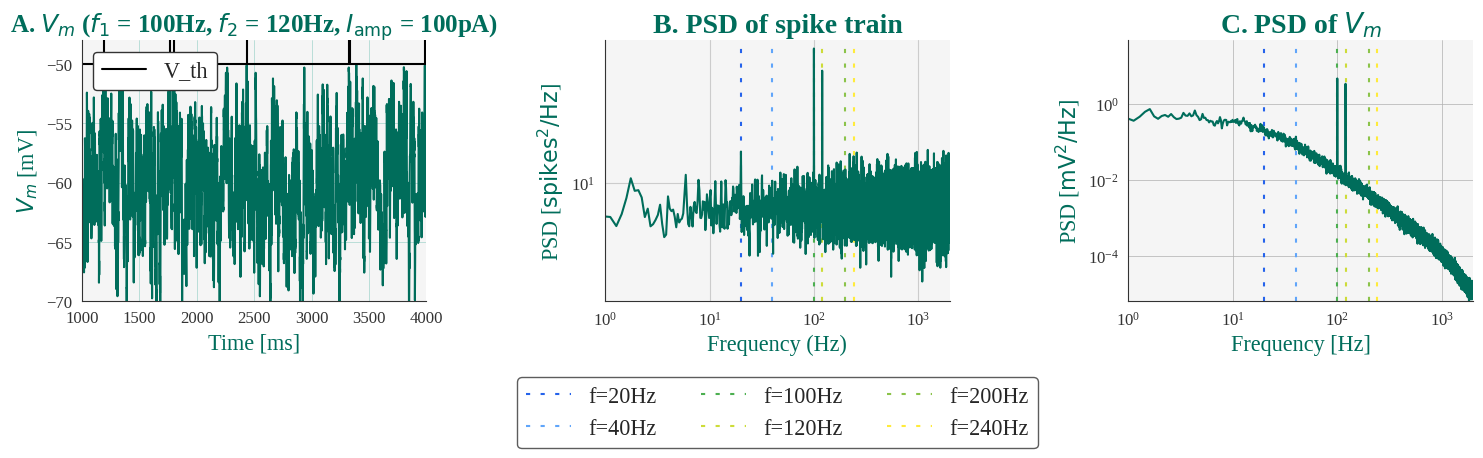

In [56]:
plot_results(sim_time=100e3, SD_values=[250], legend=True,
             a_values=[100], f_values=[100], second_sine=True, beat=20, psd_segments=16, harmonics=2,
             noisy=True, xLim=3, seed=100, bin_size=0.25, resolution=0.25, harmonics_beat=2, save_fig=True)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat)
0,"[1000, 1020]",20,500,-50.000758,49.05,36.66,12.86,1020.0,5.14,7.13,3.65,1.8,7.1


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat)
0,"[1000, 1020]",20,1000,-50.000394,164.94,134.82,41.29,1020.0,11.33,11.9,5.94,3.7,11.1


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/main_64.png


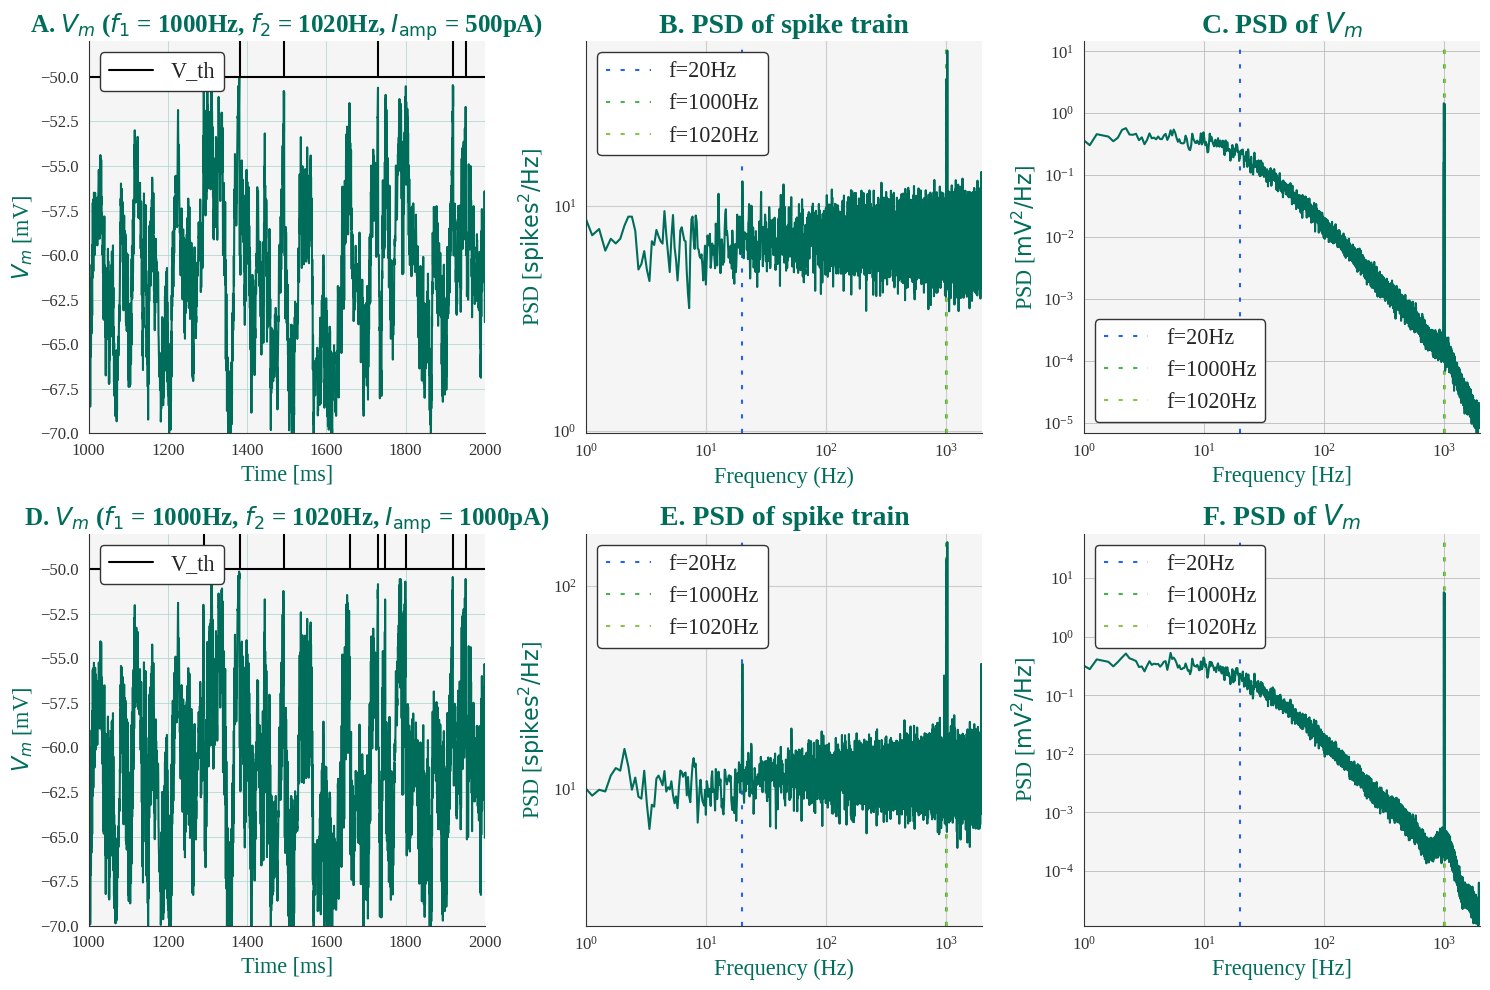

In [57]:
plot_results(sim_time=100e3, SD_values=[250],
             a_values=[500,1000], f_values=[1000], second_sine=True, beat=20, y_min=5e-10, harmonics=1,
             noisy=True, xLim=True, seed=281532, bin_size=0.25, resolution=0.25, harmonics_beat=1, save_fig=True)

In [ ]:
"""stochastic resonance"""
plot_results(sim_time=100000, SD_values=[0,100],
             a_values=[100],f_values=[10], 
             noisy=True, xLim=1, seed=5, bin_size=0.25, second_sine=False,
            harmonics=3, save_fig=False)
